# Business Case Study - Staff Planning

# Problem Statement

 The insurance approval process, i.e., underwriting is one of the important and time-consuming tasks in an insurance application processing. When you submit your insurance application, the underwriter of the company evaluates it based on the details that you provide using a rule-based or an ML model and decides whether or not to approve your application. An insurance company InsurePlus wants you to help them with finding the optimal number of staff that they need for their insurance application approval process for the calendar year 2021. In the industry, the number of staffs is considered as a continuous variable. This is also called a staff Full-Time Equivalent. For example, if a full-time employee (FTE =1) works for 50 hours a week, 10 hours corresponds to 0.2 FTEs.

- The company operates in three states A, B, and C.
- The company can either handle an application with the staff that they hire or outsource it to a vendor. (Assume that there is no capacity limitation to outsourcing.)
- If they hire staff, he/she can handle 40 insurance applications per month when he/she works 100% of the workdays. However, there are days that he/she will be unavailable to process applications due to training, off days, etc.
- A staff member’s availability (in percentage) to work on processing the insurance applications for each month is shown in the table given below. As mentioned before, with 100% availability, each member can handle 40 applications.

A special note of practical relevance: In the industry, staff availability is predicted using a time-motion study. But in this case, you have been given fixed numbers for each month. States A and B have a regulatory restriction that the outsourced insurance applications cannot be more than 30% and 40% of the total number of applications for each month, respectively. The objective is to optimise the total cost for the application approval process by distributing the right number of applications between the FTEs and the vendors while meeting the monthly demand for each state at the same time.



## Importing the libraries and reading the dataset

In [39]:
# Importing Libraries 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from pyomo.environ import *

In [40]:
from __future__ import division
from pyomo.opt import SolverFactory

In [41]:
# Reading the data from Excel workbook - Staffing.xlsx

InputData = 'Staffing+Data.xlsx'

#Read the data from Demand Data sheet

Demand = pd.read_excel(InputData,sheet_name='DemandData')

#Read the data from Staff Availability sheet

Availability = pd.read_excel (InputData,sheet_name='StaffAvailability')

#Read the data from Cost sheet

Cost = pd.read_excel (InputData,sheet_name='Cost')

#Max Applications Handled by FTE per month

transcost = pd.read_excel( InputData, sheet_name ='ServiceRate')

In [42]:
#Printing the dataframe Demand

Demand.head()

,State,Month,Demand
0,A,Jan,5240
1,A,Feb,4878
2,A,Mar,5942
3,A,Apr,2297
4,A,May,1992


In [43]:
#Printing the dataframe Availability

Availability.head()

,State,Month,LB,UB,StaffAvPer
0,A,Jan,0.70,0.90,0.81
1,A,Feb,0.65,0.85,0.76
2,A,Mar,0.70,0.80,0.75
3,A,Apr,0.75,0.85,0.80
4,A,May,0.70,0.85,0.78


In [44]:
#Printing the dataframe Cost

Cost.head()

,State,Month,AnnualSalary,MonthlySalary,UnitOutSourceCost
0,A,Jan,60000,5000.0,180
1,A,Feb,60000,5000.0,180
2,A,Mar,60000,5000.0,180
3,A,Apr,60000,5000.0,180
4,A,May,60000,5000.0,180


In [45]:
# Consolidating the three dataframes into single dataframe for further analysis

data=pd.merge(Demand,Availability ,on=['State','Month'])

Staff=pd.merge(data,Cost, on = ['State','Month'])

Staff.head()

,State,Month,Demand,LB,UB,StaffAvPer,AnnualSalary,MonthlySalary,UnitOutSourceCost
0,A,Jan,5240,0.70,0.90,0.81,60000,5000.0,180
1,A,Feb,4878,0.65,0.85,0.76,60000,5000.0,180
2,A,Mar,5942,0.70,0.80,0.75,60000,5000.0,180
3,A,Apr,2297,0.75,0.85,0.80,60000,5000.0,180
4,A,May,1992,0.70,0.85,0.78,60000,5000.0,180


In [46]:
#Checking the Shape of Final dataframe

Staff.shape

(36, 9)

In [47]:
#Checking any null values present in the final dataframe

Staff.isnull().sum()

State                0
Month                0
Demand               0
LB                   0
UB                   0
StaffAvPer           0
AnnualSalary         0
MonthlySalary        0
UnitOutSourceCost    0
dtype: int64

# Question 1

The company wants to know the optimised staffing recommendations for the business case described. 
Write the mathematical model for the deterministic optimisation problem. Define and explain your decision variables, objective function and the constraint. (Hint: Use months of the year as the model timeline).



##  Mathematical formulation / Pyomo components

---

**Sets:** 

The indexes for the given problem are, <br>
- State, $i \in State$
- Month, $j \in Month$

---

**Parameters:** 

- $\text{x}_{i,j} \text{ - Applications processed by FTE}$ <br>


- $\text{y}_{i,j} \text{ - Applications outsourced}$ <br>


- $\text{FTE_Salary}_{i,j} \text{ - Monthly Salary of FTE}$ <br>


- $\text{UnitOutSourceCost}_{i,j} \text{ - Unit Cost for outsourcing 1 application}$ <br>


- $\text{StaffAvPer}_{i,j} \text{ - Average availability of FTE}$ <br>


- $\text{StaffAv_LB}_{i,j} \text{ - Minimum availability of FTE}$ <br>


- $\text{StaffAv_UB}_{i,j} \text{ - Maximum availability of FTE}$ <br>


- $\text{FTE_AppServRate} \text{ - Number of insurance applications that can be processed by an FTE in a month when working with 100 percent availability}$ <br>
                                                                                                                                                                                                                   
---

**Decision variables:**
                                                                                                             
- Total number of  applications processed by FTE for each state and month combination <br>

 $\text{x}_{i,j} \,\,\,\,\,\,\, \text{where} \ i \in State, j \in Month $<br>
 
 
- Total number of  applications outsourced for each state and month combination <br>

 $\text{y}_{i,j} \,\,\,\,\,\,\, \text{where} \ i \in State, y \in Month $<br>


---

**Objective Function:** <br>

To minimize the total cost of insurance approval process by distributing the right number of applications between FTE and outsourced.



\begin{align}
\textrm{min} (\sum \limits _{i,j} \text{x}_{i,j}* \text{FTE_Salary}_{i,j} + \sum \limits _{i,j} \text{y}_{i,j}* \text{UnitOutSourceCost}_{i,j})
\end{align}
where $i \in State$ and $j \in Month$

---

**Constraints:**


- **Demand Constraint** :- Demand of Insurance for each state and month combination


>- $\sum \limits _{i,j} \text{x}_{i,j}* \text{StaffAvPer}_{i,j}*\text{FTE_AppServRate} == \text{demand} \ \ \ \ \forall  {i \in State, j \in Month}$


- **Staff Availability** :- Staff Availability for best and worst case scenerios.


>- $ \text{StaffAv_LB}_{i,j}  > \text{lb}_{i,j} \ \ \ \ \forall  {i \in State, j \in Month}$

>- $ \text{StaffAv_UB}_{i,j}  < \text{ub}_{i,j} \ \ \ \ \forall  {i \in State, j \in Month}$



- **Outsourcing Regulations** :- Regulatory Regulations on States A & B for outsourcing applications.

>- $ \text{y}_{i,j}  < (\text0.3*\text{demand}_{i,j}) \,\,\,\,\,\,\, \text{where} \ i \in A , j \in Month $

>- $ \text{y}_{i,j}  < (\text0.4*\text{demand}_{i,j}) \,\,\,\,\,\,\, \text{where} \ i \in B , j \in Month $


# Question 2

Code the problem is Python and use any optimization package to solve it. Add comments to your code to explain each step. 

## Data pre-processing 

In [48]:
# Create the required Python data structures for indexes and parameters

#Extracting States into a list

State = Staff['State'].unique()

# Extracting Months into a list

Month = Staff['Month'].unique()

# No of applications processed when FTE is 100% available

FTE_AppServRate = 40

# Create a Dictionary object Demand with index: 'State' and 'Month' and Value as "Demand" column from the Staff Dataframe

Demand = Staff.set_index(['State','Month'])['Demand'].to_dict()

# Create a Dictionary object FTE_Salary with index: 'State' and 'Month' and Value as "MonthlySalary" column 
#from the Staff Dataframe

FTE_Salary = Staff.set_index(['State','Month'])['MonthlySalary'].to_dict()

# Create a Dictionary object UnitOutSourceCost with index: 'State' and 'Month' and Value as "UnitOutSourceCost" column 
#from the Staff Dataframe

UnitOutSourceCost = Staff.set_index(['State','Month'])['UnitOutSourceCost'].to_dict()

# Create a Dictionary object StaffAvPer with index: 'State' and 'Month' and Value as "StaffAvPer" column 
#from the Staff Dataframe

StaffAvPer = Staff.set_index(['State','Month'])['StaffAvPer'].to_dict()

# Create a Dictionary object StaffAv_LB with index: 'State' and 'Month' and Value as "LB" column 
#from the Staff Dataframe

StaffAv_LB = Staff.set_index(['State','Month'])['LB'].to_dict()

# Create a Dictionary object StaffAv_UB with index: 'State' and 'Month' and Value as "UB" column 
#from the Staff Dataframe

StaffAv_UB = Staff.set_index(['State','Month'])['UB'].to_dict()

In [49]:
print(Demand)

{('A', 'Jan'): 5240, ('A', 'Feb'): 4878, ('A', 'Mar'): 5942, ('A', 'Apr'): 2297, ('A', 'May'): 1992, ('A', 'Jun'): 2275, ('A', 'Jul'): 5334, ('A', 'Aug'): 3371, ('A', 'Sep'): 3759, ('A', 'Oct'): 3529, ('A', 'Nov'): 4284, ('A', 'Dec'): 5183, ('B', 'Jan'): 4927, ('B', 'Feb'): 2628, ('B', 'Mar'): 2974, ('B', 'Apr'): 2338, ('B', 'May'): 4020, ('B', 'Jun'): 3147, ('B', 'Jul'): 4271, ('B', 'Aug'): 2620, ('B', 'Sep'): 4517, ('B', 'Oct'): 4155, ('B', 'Nov'): 3137, ('B', 'Dec'): 4227, ('C', 'Jan'): 1162, ('C', 'Feb'): 1967, ('C', 'Mar'): 1898, ('C', 'Apr'): 2261, ('C', 'May'): 2030, ('C', 'Jun'): 1642, ('C', 'Jul'): 2489, ('C', 'Aug'): 2496, ('C', 'Sep'): 922, ('C', 'Oct'): 2421, ('C', 'Nov'): 963, ('C', 'Dec'): 1998}


In [50]:
print(StaffAvPer)

{('A', 'Jan'): 0.81, ('A', 'Feb'): 0.76, ('A', 'Mar'): 0.75, ('A', 'Apr'): 0.8, ('A', 'May'): 0.78, ('A', 'Jun'): 0.73, ('A', 'Jul'): 0.68, ('A', 'Aug'): 0.76, ('A', 'Sep'): 0.81, ('A', 'Oct'): 0.73, ('A', 'Nov'): 0.68, ('A', 'Dec'): 0.65, ('B', 'Jan'): 0.81, ('B', 'Feb'): 0.76, ('B', 'Mar'): 0.75, ('B', 'Apr'): 0.8, ('B', 'May'): 0.78, ('B', 'Jun'): 0.73, ('B', 'Jul'): 0.68, ('B', 'Aug'): 0.76, ('B', 'Sep'): 0.81, ('B', 'Oct'): 0.73, ('B', 'Nov'): 0.68, ('B', 'Dec'): 0.65, ('C', 'Jan'): 0.81, ('C', 'Feb'): 0.76, ('C', 'Mar'): 0.75, ('C', 'Apr'): 0.8, ('C', 'May'): 0.78, ('C', 'Jun'): 0.73, ('C', 'Jul'): 0.68, ('C', 'Aug'): 0.76, ('C', 'Sep'): 0.81, ('C', 'Oct'): 0.73, ('C', 'Nov'): 0.68, ('C', 'Dec'): 0.65}


In [51]:
print(StaffAv_LB)

{('A', 'Jan'): 0.7, ('A', 'Feb'): 0.65, ('A', 'Mar'): 0.7, ('A', 'Apr'): 0.75, ('A', 'May'): 0.7, ('A', 'Jun'): 0.65, ('A', 'Jul'): 0.6, ('A', 'Aug'): 0.65, ('A', 'Sep'): 0.7, ('A', 'Oct'): 0.65, ('A', 'Nov'): 0.6, ('A', 'Dec'): 0.6, ('B', 'Jan'): 0.7, ('B', 'Feb'): 0.65, ('B', 'Mar'): 0.7, ('B', 'Apr'): 0.75, ('B', 'May'): 0.7, ('B', 'Jun'): 0.65, ('B', 'Jul'): 0.6, ('B', 'Aug'): 0.65, ('B', 'Sep'): 0.7, ('B', 'Oct'): 0.65, ('B', 'Nov'): 0.6, ('B', 'Dec'): 0.6, ('C', 'Jan'): 0.7, ('C', 'Feb'): 0.65, ('C', 'Mar'): 0.7, ('C', 'Apr'): 0.75, ('C', 'May'): 0.7, ('C', 'Jun'): 0.65, ('C', 'Jul'): 0.6, ('C', 'Aug'): 0.65, ('C', 'Sep'): 0.7, ('C', 'Oct'): 0.65, ('C', 'Nov'): 0.6, ('C', 'Dec'): 0.6}


In [52]:
print(StaffAv_UB)

{('A', 'Jan'): 0.9, ('A', 'Feb'): 0.85, ('A', 'Mar'): 0.8, ('A', 'Apr'): 0.85, ('A', 'May'): 0.85, ('A', 'Jun'): 0.8, ('A', 'Jul'): 0.75, ('A', 'Aug'): 0.85, ('A', 'Sep'): 0.9, ('A', 'Oct'): 0.8, ('A', 'Nov'): 0.75, ('A', 'Dec'): 0.7, ('B', 'Jan'): 0.9, ('B', 'Feb'): 0.85, ('B', 'Mar'): 0.8, ('B', 'Apr'): 0.85, ('B', 'May'): 0.85, ('B', 'Jun'): 0.8, ('B', 'Jul'): 0.75, ('B', 'Aug'): 0.85, ('B', 'Sep'): 0.9, ('B', 'Oct'): 0.8, ('B', 'Nov'): 0.75, ('B', 'Dec'): 0.7, ('C', 'Jan'): 0.9, ('C', 'Feb'): 0.85, ('C', 'Mar'): 0.8, ('C', 'Apr'): 0.85, ('C', 'May'): 0.85, ('C', 'Jun'): 0.8, ('C', 'Jul'): 0.75, ('C', 'Aug'): 0.85, ('C', 'Sep'): 0.9, ('C', 'Oct'): 0.8, ('C', 'Nov'): 0.75, ('C', 'Dec'): 0.7}


#### Expected output:

Create a data frame containing the number of outsourced applications  and the number of FTEs for each state-month combination. You can choose to have extra columns like staff availability, demand etc. in your dataframe apart from the ones mentioned earlier. 

In [53]:
# Creating a model instance

model = ConcreteModel()

In [54]:
# Define Pyomo sets and Parameters

model.i = Set(initialize=State.tolist(),doc='States')

model.j = Set(initialize=Month.tolist(),doc='Months')

model.demand = Param(model.i,model.j,initialize = Demand,doc='Demand')

model.sa = Param(model.i,model.j,initialize = StaffAvPer,doc = 'StaffAvPercent')

In [55]:
# Decision variables

model.x = Var(model.i,model.j,doc='No of FTE',domain = NonNegativeReals)

model.y = Var(model.i,model.j,doc='No of Outsource App',domain = NonNegativeIntegers)

In [56]:
# Constraints

# Demand Constraint

def total_demand(m,i,j):
    return (m.x[i,j]*40*m.sa[i,j] + m.y[i,j] == m.demand[i,j])
            
model.total_demand = Constraint(model.i,model.j, rule=total_demand)

# Outsourcing Regulation

model.outsource_demand = ConstraintList()
for j in model.j:
    for i in model.i:
        if i == 'A':
            model.outsource_demand.add(expr = model.y[i,j] <= 0.3*model.demand[i,j])
        elif i == 'B':
            model.outsource_demand.add(expr = model.y[i,j] <= 0.4*model.demand[i,j])

In [57]:
# Objective function

model.value = Objective(expr = sum(sum(model.x[i,j]*FTE_Salary[i,j]
                                       + model.y[i,j]*UnitOutSourceCost[i,j] for i in model.i) for j in model.j), 
                        sense= minimize)

In [58]:
# Invoking the solver

result = SolverFactory('glpk').solve(model)
result.write()

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: 17962336.4487699
  Upper bound: 17962336.4487699
  Number of objectives: 1
  Number of constraints: 61
  Number of variables: 73
  Number of nonzeros: 97
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Termination condition: optimal
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 0
      Number of created subproblems: 0
  Error rc: 0
  Time: 0.051436662673950195
# ----------------------------------------------------------
#   Solution Information
# -----------

In [59]:
#Printing the output of the Model

model.pprint()

8 Set Declarations
    demand_index : Size=1, Index=None, Ordered=True
        Key  : Dimen : Domain : Size : Members
        None :     2 :    i*j :   36 : {('A', 'Jan'), ('A', 'Feb'), ('A', 'Mar'), ('A', 'Apr'), ('A', 'May'), ('A', 'Jun'), ('A', 'Jul'), ('A', 'Aug'), ('A', 'Sep'), ('A', 'Oct'), ('A', 'Nov'), ('A', 'Dec'), ('B', 'Jan'), ('B', 'Feb'), ('B', 'Mar'), ('B', 'Apr'), ('B', 'May'), ('B', 'Jun'), ('B', 'Jul'), ('B', 'Aug'), ('B', 'Sep'), ('B', 'Oct'), ('B', 'Nov'), ('B', 'Dec'), ('C', 'Jan'), ('C', 'Feb'), ('C', 'Mar'), ('C', 'Apr'), ('C', 'May'), ('C', 'Jun'), ('C', 'Jul'), ('C', 'Aug'), ('C', 'Sep'), ('C', 'Oct'), ('C', 'Nov'), ('C', 'Dec')}
    i : States
        Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    3 : {'A', 'B', 'C'}
    j : Months
        Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :   12 : {'Jan', 'Feb', 'Mar', 'Apr',

In [60]:
# Print the value of the objective function

optimized_cost = round(model.value()/1000000,2)
optimized_cost

17.96

**`Checkpoint 1:`** Seems like the company has to spend around 17.9 m$ in total for the application approval process.

In [61]:
#Creating an empty list

Output_actual = []

# For every iteration, the code below will create a list containing 9 values - State, Month, No of FTE,Demand,
#No of outsource app,No of FTE processed App,Estimated Cost,percent outsourced app,average cost per application

for i in model.i:
    for j in model.j:
        
        #cost for the application approval process
        no_of_fte=model.x[i,j].value
        demand = model.demand[i, j]
        no_of_outsource_app = model.y[i,j].value
        no_of_FTE_processed_app = model.x[i,j].value*40*model.sa[i,j]
        cost = model.x[i,j].value*FTE_Salary[i,j] + model.y[i,j].value*UnitOutSourceCost[i,j]
        percent_outsourced_app = round((no_of_outsource_app/demand)*100,2)
        avg_cost_per_app = round(cost/demand,2)
        
        Output_actual.append([i, j, no_of_fte,demand, no_of_outsource_app,no_of_FTE_processed_app, cost, 
                              percent_outsourced_app,avg_cost_per_app])
        
print(Output_actual)

[['A', 'Jan', 161.728395061728, 5240, 0.0, 5239.999999999987, 808641.97530864, 0.0, 154.32], ['A', 'Feb', 160.460526315789, 4878, 0.0, 4877.999999999985, 802302.631578945, 0.0, 164.47], ['A', 'Mar', 198.066666666667, 5942, 0.0, 5942.000000000011, 990333.333333335, 0.0, 166.67], ['A', 'Apr', 71.78125, 2297, 0.0, 2297.0, 358906.25, 0.0, 156.25], ['A', 'May', 63.8461538461538, 1992, 0.0, 1991.9999999999986, 319230.76923076896, 0.0, 160.26], ['A', 'Jun', 77.9109589041096, 2275, 0.0, 2275.0000000000005, 389554.794520548, 0.0, 171.23], ['A', 'Jul', 137.279411764706, 5334, 1600.0, 3734.000000000003, 974397.05882353, 30.0, 182.68], ['A', 'Aug', 110.888157894737, 3371, 0.0, 3371.0000000000055, 554440.7894736851, 0.0, 164.47], ['A', 'Sep', 116.018518518519, 3759, 0.0, 3759.000000000016, 580092.592592595, 0.0, 154.32], ['A', 'Oct', 120.856164383562, 3529, 0.0, 3529.0000000000105, 604280.82191781, 0.0, 171.23], ['A', 'Nov', 110.257352941176, 4284, 1285.0, 2998.9999999999873, 782586.76470588, 30.0,

In [62]:
# Creating dataframe for the results

Output_actual = pd.DataFrame(Output_actual, columns = ['State', 'Month', 'No of FTE',"Demand",'No of Outsource App',
                                                       "No of FTE processed App" , 'Estimated Cost', 'Percent Outsourced App',
                                                       'Average Cost Per Application'])

Output_actual[['Estimated Cost in mn $']] = Output_actual[['Estimated Cost']]/1000000

Output_actual['Demand'] = Output_actual['Demand'].astype(int)

Output_actual['No of Outsource App'] = Output_actual['No of Outsource App'].astype(int)

Output_actual['No of FTE processed App'] = Output_actual['No of FTE processed App'].astype(int)

Output_actual = Output_actual.round({"No of FTE":1, "No of Outsource App":0, "Estimated Cost in mn $":1})

In [63]:
#Printing top 5 Rows of Final dataframe

Output_actual.head()

,State,Month,No of FTE,Demand,No of Outsource App,No of FTE processed App,Estimated Cost,Percent Outsourced App,Average Cost Per Application,Estimated Cost in mn $
0,A,Jan,161.7,5240,0,5239,808641.975309,0.0,154.32,0.8
1,A,Feb,160.5,4878,0,4877,802302.631579,0.0,164.47,0.8
2,A,Mar,198.1,5942,0,5942,990333.333333,0.0,166.67,1.0
3,A,Apr,71.8,2297,0,2297,358906.250000,0.0,156.25,0.4
4,A,May,63.8,1992,0,1991,319230.769231,0.0,160.26,0.3


In [64]:
# Writing the results in to an Excel sheet

with pd.ExcelWriter('Output_Actual_Q2.xlsx') as writer:
    Output_actual.to_excel(writer)

# Question 3

#### Worst-case and best-case analysis based on the staffs' availability.

Assuming that the distribution is the same across all the states,

#### 3.1 Worst case analysis 

- 3.1.1 What is the optimal number of staff members for the worst case? 

- 3.1.2 What is the percentage of outsourcing for the worst case? 

- 3.1.3 What is the average cost per application for the worst case?


#### 3.2 Best case analysis 

- 3.2.1 What is the optimal number of staff members for the best case? 

- 3.2.2 What is the percentage of outsourcing for the best case? 

- 3.2.3 What is the average cost per application for the best case?


#### Expected output:

For each of the subtasks (3.1 and 3.2) create a data frame containing the number of outsourced applications and the number of FTEs for each state-month combination. You can choose to have extra columns like staff availability, demand etc. in your dataframe apart from the ones mentioned earlier. Also, print the overall average percentage of outsourced applications and the overall average cost per application. 

### 3.1 Worst Case Analysis 

#### 3.1.1 Optimal number of staff members

In [65]:
# Creating a model instance

model1 = ConcreteModel()

In [66]:
# Define Pyomo sets and Parameters


model1.i = Set(initialize=State.tolist(),doc='States')

model1.j = Set(initialize=Month.tolist(),doc='Months')

model1.demand = Param(model1.i,model1.j,initialize = Demand,doc='Demand')

model1.sa = Param(model1.i,model1.j,initialize = StaffAv_LB,doc = 'StaffLowerBoundPercent')

In [67]:
# Decision variables

model1.x = Var(model1.i,model1.j,doc='No of FTE',domain = NonNegativeReals)

model1.y = Var(model1.i,model1.j,doc='No of Outsource App',domain = NonNegativeIntegers)

In [68]:
# Constraints

def total_demand(m, i, j):
    return (m.x[i, j] * 40 * m.sa[i, j] + m.y[i, j] == m.demand[i, j])


model1.total_demand = Constraint(model1.i, model1.j, rule=total_demand)

# Outsourcing Regulation

model1.outsource_demand = ConstraintList()
for j in model1.j:
    for i in model1.i:
        if i == 'A':
            model1.outsource_demand.add(expr = model1.y[i,j] <= 0.3*model1.demand[i,j])
        elif i == 'B':
            model1.outsource_demand.add(expr = model1.y[i,j] <= 0.4*model1.demand[i,j])

In [69]:
# Objective function

model1.value = Objective(expr = sum(sum(model1.x[i,j]*FTE_Salary[i,j]
                                        + model1.y[i,j]*UnitOutSourceCost[i,j] for i in model1.i) for j in model1.j),
                         sense= minimize)

In [70]:
# Invoking the solver

result = SolverFactory('glpk').solve(model1)
result.write()

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: 19599482.5167888
  Upper bound: 19599482.5167888
  Number of objectives: 1
  Number of constraints: 61
  Number of variables: 73
  Number of nonzeros: 97
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Termination condition: optimal
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 0
      Number of created subproblems: 0
  Error rc: 0
  Time: 0.051566123962402344
# ----------------------------------------------------------
#   Solution Information
# -----------

In [71]:
# Creating dataframe for the results

model1.pprint()

8 Set Declarations
    demand_index : Size=1, Index=None, Ordered=True
        Key  : Dimen : Domain : Size : Members
        None :     2 :    i*j :   36 : {('A', 'Jan'), ('A', 'Feb'), ('A', 'Mar'), ('A', 'Apr'), ('A', 'May'), ('A', 'Jun'), ('A', 'Jul'), ('A', 'Aug'), ('A', 'Sep'), ('A', 'Oct'), ('A', 'Nov'), ('A', 'Dec'), ('B', 'Jan'), ('B', 'Feb'), ('B', 'Mar'), ('B', 'Apr'), ('B', 'May'), ('B', 'Jun'), ('B', 'Jul'), ('B', 'Aug'), ('B', 'Sep'), ('B', 'Oct'), ('B', 'Nov'), ('B', 'Dec'), ('C', 'Jan'), ('C', 'Feb'), ('C', 'Mar'), ('C', 'Apr'), ('C', 'May'), ('C', 'Jun'), ('C', 'Jul'), ('C', 'Aug'), ('C', 'Sep'), ('C', 'Oct'), ('C', 'Nov'), ('C', 'Dec')}
    i : States
        Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    3 : {'A', 'B', 'C'}
    j : Months
        Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :   12 : {'Jan', 'Feb', 'Mar', 'Apr',

In [72]:
# Print the value of the objective function

optimized_cost_worst = round(model1.value()/1000000,2)
optimized_cost_worst

19.6

**`Checkpoint 2:`** The company has to spend around 19.6 m$ in total for the application approval process if the staffs are working with the minimum availability.

In [73]:
#Creating an empty list
Output_worst = []


# For every iteration, the code below will create a list containing 9 values - State, Month, No of FTE,Demand,
#No of outsource app,No of FTE processed App,Estimated Cost,percent outsourced app,average cost per application

for i in model1.i:
    for j in model1.j:
       
        no_of_fte = model1.x[i, j].value
        demand = model1.demand[i, j]
        no_of_outsource_app = model1.y[i, j].value
        no_of_FTE_processed_app = model1.x[i,j].value*40*model1.sa[i,j]
        cost = model1.x[i, j].value*FTE_Salary[i, j] + model1.y[i, j].value*UnitOutSourceCost[i, j]

        percent_outsourced_app = round((no_of_outsource_app/demand)*100,1)
        avg_cost_per_app = round(cost/demand,1)

        Output_worst.append([i, j, no_of_fte,demand, no_of_outsource_app,no_of_FTE_processed_app, 
                             cost, percent_outsourced_app,avg_cost_per_app])
print(Output_worst)

[['A', 'Jan', 187.142857142857, 5240, 0.0, 5239.999999999995, 935714.285714285, 0.0, 178.6], ['A', 'Feb', 131.346153846154, 4878, 1463.0, 3415.0000000000045, 920070.7692307701, 30.0, 188.6], ['A', 'Mar', 212.214285714286, 5942, 0.0, 5942.000000000008, 1061071.42857143, 0.0, 178.6], ['A', 'Apr', 76.5666666666667, 2297, 0.0, 2297.0000000000014, 382833.33333333355, 0.0, 166.7], ['A', 'May', 71.1428571428571, 1992, 0.0, 1991.9999999999986, 355714.2857142855, 0.0, 178.6], ['A', 'Jun', 61.2692307692308, 2275, 682.0, 1593.0000000000011, 429106.153846154, 30.0, 188.6], ['A', 'Jul', 155.583333333333, 5334, 1600.0, 3733.999999999992, 1065916.666666665, 30.0, 199.8], ['A', 'Aug', 90.7692307692308, 3371, 1011.0, 2360.000000000001, 635826.153846154, 30.0, 188.6], ['A', 'Sep', 134.25, 3759, 0.0, 3758.9999999999995, 671250.0, 0.0, 178.6], ['A', 'Oct', 95.0384615384615, 3529, 1058.0, 2470.999999999999, 665632.3076923075, 30.0, 188.6], ['A', 'Nov', 124.958333333333, 4284, 1285.0, 2998.9999999999923, 85

In [74]:
# Creating dataframe for the results

Output_worst = pd.DataFrame(Output_worst, columns = ['State', 'Month', 'No of FTE Worst',"Demand",'No of Outsource App Worst',
                                                     "No of FTE Processed App Worst" , 
                                                     'Estimated Cost Worst', 'Percent Outsourced App Worst', 
                                                     'Average Cost Per Application Worst'])

Output_worst['Estimated Cost in mn $ Worst'] = Output_worst[['Estimated Cost Worst']]/1000000

Output_worst['Demand'] = Output_worst['Demand'].astype(int)

Output_worst['No of Outsource App Worst'] = Output_worst['No of Outsource App Worst'].astype(int)

Output_worst['No of FTE Processed App Worst'] = Output_worst['No of FTE Processed App Worst'].astype(int)

Output_worst = Output_worst.round({"No of FTE Worst":1, "No of Outsource App Worst":0, "Estimated Cost in mn $ Worst":1})

In [75]:
#Printing top 5 Rows of Final dataframe

Output_worst.head()

,State,Month,No of FTE Worst,Demand,No of Outsource App Worst,No of FTE Processed App Worst,Estimated Cost Worst,Percent Outsourced App Worst,Average Cost Per Application Worst,Estimated Cost in mn $ Worst
0,A,Jan,187.1,5240,0,5239,9.357143e+05,0.0,178.6,0.9
1,A,Feb,131.3,4878,1463,3415,9.200708e+05,30.0,188.6,0.9
2,A,Mar,212.2,5942,0,5942,1.061071e+06,0.0,178.6,1.1
3,A,Apr,76.6,2297,0,2297,3.828333e+05,0.0,166.7,0.4
4,A,May,71.1,1992,0,1991,3.557143e+05,0.0,178.6,0.4


In [76]:
#Various Parameters
total_outsourcing =  sum(Output_worst['No of Outsource App Worst'])

total_cost = sum(Output_worst['Estimated Cost Worst'])

optimal_staff_members = round(Output_worst['No of FTE Worst'].mean(),1)

total_demand =  sum(Output_worst['Demand'])

average_cost_per_appln = round(total_cost/total_demand,2)

percent_outsourced_app_total = round((total_outsourcing/total_demand)*100,1)

print("Total Outsourced Application: ", total_outsourcing)

print("Total Demand Application: ", total_demand)

print("Optimal Staff Members : ", optimal_staff_members)

Total Outsourced Application:  39808
Total Demand Application:  113294
Optimal Staff Members :  76.7


#### 3.1.2 Percentage of outsourced applications 

In [77]:
# write your code here

print("Total Outsourced Application % is : ", percent_outsourced_app_total)

Total Outsourced Application % is :  35.1


#### 3.1.3 Average cost per application

In [78]:
# write your code here

print("Average Cost per Application: ", average_cost_per_appln)

Average Cost per Application:  173.0


In [79]:
# Writing the results in to an Excel sheet

with pd.ExcelWriter('Output_Worst_Q3.xlsx') as writer:
    Output_worst.to_excel(writer)

### 3.2  Best Case Analysis 

#### 3.2.1 Optimal number of staff members


In [80]:
# Creating a model instance

model2 = ConcreteModel()

In [81]:
# Define Pyomo sets and Parameters

model2.i = Set(initialize=State.tolist(),doc='States')

model2.j = Set(initialize=Month.tolist(),doc='Months')

model2.demand = Param(model2.i,model2.j,initialize = Demand,doc='Demand')

model2.sa = Param(model2.i,model2.j,initialize = StaffAv_UB,doc = 'StaffUpperBoundPercent')

In [82]:
# Decision variables

model2.x = Var(model2.i,model2.j,doc='No of FTE',domain = NonNegativeReals)

model2.y = Var(model2.i,model2.j,doc='No of Outsource App',domain = NonNegativeIntegers)

In [83]:
# Constraints

# Demand Constraint

def total_demand(m, i, j):
    return (m.x[i, j] * 40 * m.sa[i, j] + m.y[i, j] == m.demand[i, j])


model2.total_demand = Constraint(model2.i, model2.j, rule=total_demand)

# Outsourcing Regulation

model2.outsource_demand = ConstraintList()
for j in model2.j:
    for i in model2.i:
        if i == 'A':
            model2.outsource_demand.add(expr = model2.y[i,j] <= 0.3*model2.demand[i,j])
        elif i == 'B':
            model2.outsource_demand.add(expr = model2.y[i,j] <= 0.4*model2.demand[i,j])

In [84]:
# Objective function

model2.value = Objective(expr = sum(sum(model2.x[i,j]*FTE_Salary[i,j]+ 
                                        model2.y[i,j]*UnitOutSourceCost[i,j] for i in model2.i) for j in model2.j),
                         sense= minimize)


In [85]:
# Invoking the solver

result = SolverFactory('glpk').solve(model2)
result.write()

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: 16527535.6379357
  Upper bound: 16527535.6379357
  Number of objectives: 1
  Number of constraints: 61
  Number of variables: 73
  Number of nonzeros: 97
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Termination condition: optimal
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 0
      Number of created subproblems: 0
  Error rc: 0
  Time: 0.06364989280700684
# ----------------------------------------------------------
#   Solution Information
# ------------

In [86]:
#Printing the Model

model2.pprint()

8 Set Declarations
    demand_index : Size=1, Index=None, Ordered=True
        Key  : Dimen : Domain : Size : Members
        None :     2 :    i*j :   36 : {('A', 'Jan'), ('A', 'Feb'), ('A', 'Mar'), ('A', 'Apr'), ('A', 'May'), ('A', 'Jun'), ('A', 'Jul'), ('A', 'Aug'), ('A', 'Sep'), ('A', 'Oct'), ('A', 'Nov'), ('A', 'Dec'), ('B', 'Jan'), ('B', 'Feb'), ('B', 'Mar'), ('B', 'Apr'), ('B', 'May'), ('B', 'Jun'), ('B', 'Jul'), ('B', 'Aug'), ('B', 'Sep'), ('B', 'Oct'), ('B', 'Nov'), ('B', 'Dec'), ('C', 'Jan'), ('C', 'Feb'), ('C', 'Mar'), ('C', 'Apr'), ('C', 'May'), ('C', 'Jun'), ('C', 'Jul'), ('C', 'Aug'), ('C', 'Sep'), ('C', 'Oct'), ('C', 'Nov'), ('C', 'Dec')}
    i : States
        Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    3 : {'A', 'B', 'C'}
    j : Months
        Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :   12 : {'Jan', 'Feb', 'Mar', 'Apr',

In [87]:
# Print the value of the objective function

optimized_cost_best = round(model2.value()/1000000,2)
optimized_cost_best

16.53

**`Checkpoint 3:`** The company has to spend around 16.5 m$ in total for the application approval process if the staffs are working with the maximum availability.

In [88]:
#Creating an empty list

Output_best = []

# For every iteration, the code below will create a list containing 9 values - State, Month, No of FTE,Demand,
#No of outsource app,No of FTE processed App,Estimated Cost,percent outsourced app,average cost per application

for i in model2.i:
    for j in model2.j:
        # cost for the application approval process
        no_of_fte = model2.x[i, j].value
        demand = model2.demand[i, j]
        no_of_outsource_app = model2.y[i, j].value
        no_of_FTE_processed_app = model2.x[i,j].value*40*model2.sa[i,j]
        cost = model2.x[i, j].value*FTE_Salary[i, j] + model2.y[i, j].value*UnitOutSourceCost[i, j]

        percent_outsourced_app = round((no_of_outsource_app/demand)*100,1)
        avg_cost_per_app = round(cost/demand,1)

        Output_best.append([i, j, no_of_fte,demand, no_of_outsource_app,no_of_FTE_processed_app, 
                            cost, percent_outsourced_app,avg_cost_per_app])

        print(Output_best)

[['A', 'Jan', 145.555555555556, 5240, 0.0, 5240.000000000016, 727777.77777778, 0.0, 138.9]]
[['A', 'Jan', 145.555555555556, 5240, 0.0, 5240.000000000016, 727777.77777778, 0.0, 138.9], ['A', 'Feb', 143.470588235294, 4878, 0.0, 4877.999999999996, 717352.94117647, 0.0, 147.1]]
[['A', 'Jan', 145.555555555556, 5240, 0.0, 5240.000000000016, 727777.77777778, 0.0, 138.9], ['A', 'Feb', 143.470588235294, 4878, 0.0, 4877.999999999996, 717352.94117647, 0.0, 147.1], ['A', 'Mar', 185.6875, 5942, 0.0, 5942.0, 928437.5, 0.0, 156.2]]
[['A', 'Jan', 145.555555555556, 5240, 0.0, 5240.000000000016, 727777.77777778, 0.0, 138.9], ['A', 'Feb', 143.470588235294, 4878, 0.0, 4877.999999999996, 717352.94117647, 0.0, 147.1], ['A', 'Mar', 185.6875, 5942, 0.0, 5942.0, 928437.5, 0.0, 156.2], ['A', 'Apr', 67.5588235294118, 2297, 0.0, 2297.0000000000014, 337794.11764705897, 0.0, 147.1]]
[['A', 'Jan', 145.555555555556, 5240, 0.0, 5240.000000000016, 727777.77777778, 0.0, 138.9], ['A', 'Feb', 143.470588235294, 4878, 0.0, 

In [89]:
# Creating dataframe for the results

Output_best = pd.DataFrame(Output_best, columns = ['State', 'Month', 'No of FTE Best',"Demand",
                                                   'No of Outsource App Best',"No of FTE Processed App Best", 
                                                   'Estimated Cost Best', 'Percent Outsourced App Best',  
                                                   'Average Cost Per Application Best'])


Output_best[['Estimated Cost in mn $ Best']] = Output_best[['Estimated Cost Best']]/1000000

Output_best['Demand'] = Output_best['Demand'].astype(int)

Output_best['No of Outsource App Best'] = Output_best['No of Outsource App Best'].astype(int)

Output_best['No of FTE Processed App Best'] = Output_best['No of FTE Processed App Best'].astype(int)

Output_best = Output_best.round({"No of FTE Best":1, "No of Outsource App Best":0, "Estimated Cost in mn $ Best":1})

In [90]:
#Printing top 5 Rows of Final dataframe

Output_best.head()

,State,Month,No of FTE Best,Demand,No of Outsource App Best,No of FTE Processed App Best,Estimated Cost Best,Percent Outsourced App Best,Average Cost Per Application Best,Estimated Cost in mn $ Best
0,A,Jan,145.6,5240,0,5240,727777.777778,0.0,138.9,0.7
1,A,Feb,143.5,4878,0,4877,717352.941176,0.0,147.1,0.7
2,A,Mar,185.7,5942,0,5942,928437.500000,0.0,156.2,0.9
3,A,Apr,67.6,2297,0,2297,337794.117647,0.0,147.1,0.3
4,A,May,58.6,1992,0,1991,292941.176471,0.0,147.1,0.3


In [91]:
#Various Parameters

total_outsourcing =  sum(Output_best['No of Outsource App Best'])

total_cost = sum(Output_best['Estimated Cost Best'])

optimal_staff_members = round(Output_best['No of FTE Best'].mean(),1)

total_demand =  sum(Output_best['Demand'])

average_cost_per_appln = round(total_cost/total_demand,2)

percent_outsourced_app_total = round((total_outsourcing/total_demand)*100,1)

print("Total Outsourced Application: ", total_outsourcing)

print("Total Demand Application: ", total_demand)

print("Optimal Staff Members : ", optimal_staff_members)

Total Outsourced Application:  4652
Total Demand Application:  113294
Optimal Staff Members :  92.9


#### 3.2.2 Percentage of outsourced applications

In [92]:
# write your code here

print("Total Outsourced Application % is : ", percent_outsourced_app_total)

Total Outsourced Application % is :  4.1


#### 3.2.3 Average cost per application

In [93]:
# write your code here

print("Average Cost per Application: ", average_cost_per_appln)

Average Cost per Application:  145.88


In [94]:
# Writing the results in to an Excel sheet

with pd.ExcelWriter('Output_Best_Q3.xlsx') as writer:
    Output_best.to_excel(writer)

# Question 4

#### Creating Visualisations

Create the following visualisations using your preferred method (i.e. Python, PowerPoint, Power BI, etc.) and add it to your report. 

Use the solution of Q2 to create a stacked column chart that shows the percentage of applications processed by the staff and by the vendor for each month (%staff processed applications+ %vendor processed applications should add up to 100%). 
Create a graph to show how the cost per application increases with respect to any change in the parameters in your analysis.
Hint: Use the cost per application that you calculate in Questions 2 and 3 (i.e., the best case, and the worst case). 

**Note:** You can create the charts in Python or some other visualisation tools and make it a part of your final report directly.

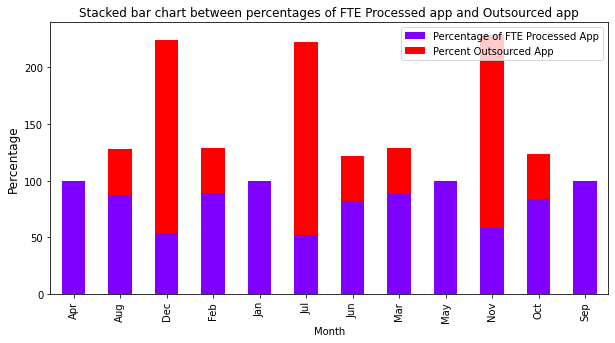

In [95]:
df = Output_actual[['Month', 'Demand', 'No of Outsource App','No of FTE processed App','Percent Outsourced App']].groupby(['Month']).sum()
df['Percentage of FTE Processed App'] = df['No of FTE processed App']/df['Demand']*100
ax = df[['Percentage of FTE Processed App','Percent Outsourced App']].plot(kind='bar', stacked=True,colormap='rainbow',figsize=(10,5))
ax.set_ylabel("Percentage", fontsize=12)
plt.title("Stacked bar chart between percentages of FTE Processed app and Outsourced app", fontsize=12)
plt.show()

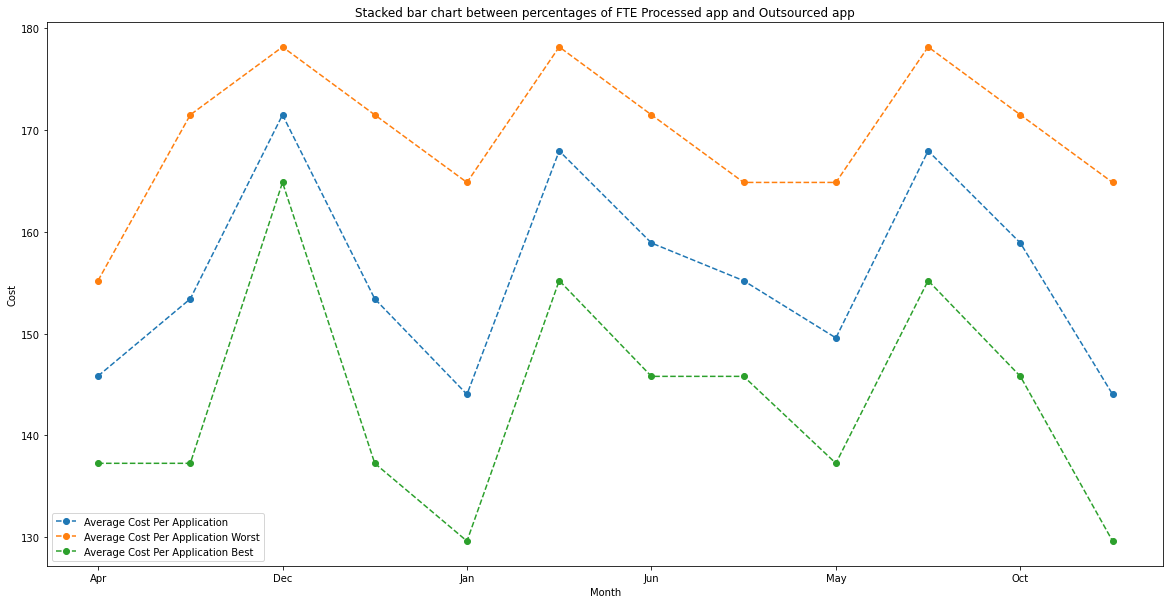

In [103]:
#Creating the chart to show cost per application in every case
df_new = pd.concat([Output_actual[['Average Cost Per Application','Month']], Output_worst['Average Cost Per Application Worst'], Output_best['Average Cost Per Application Best']], axis=1)
df_new = df_new.groupby(['Month']).mean()
df_new.plot.line(figsize=[20,10],marker = 'o',linestyle='dashed')
plt.title("Stacked bar chart between percentages of FTE Processed app and Outsourced app", fontsize=12)
plt.xlabel("Month")
plt.ylabel("Cost")
plt.show()